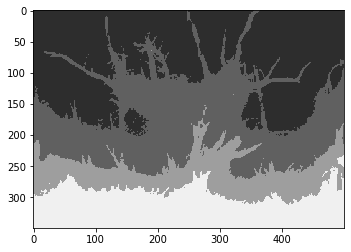

In [119]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1)
    imvec = im.reshape(imsz,3)

    indices = darkvec.argsort()
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95 # default 0.95
    im3 = np.empty(im.shape,im.dtype)

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz)
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
    cov_Ip = mean_Ip - mean_I*mean_p

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
    var_I   = mean_II - mean_I*mean_I

    a = cov_Ip/(var_I + eps)
    b = mean_p - a*mean_I

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))

    q = mean_a*im + mean_b
    return q

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray)/255
    r = 60 #default value 60
    eps = 0.0001 # default value 0.0001
    t = Guidedfilter(gray,et,r,eps)

    return t

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype)
    t = cv2.max(t,tx)

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

if __name__ == '__main__':
    # import sys
    # try:
    #     fn = sys.argv[1]
    # except:
    #     fn = './image/15.png'

    # def nothing(*argv):
    #     pass
    
    # Image path
    path_input = "Scenes"
    path_output  = "Testing"

    
    total_image = 10
    for idx in range(1, total_image+1):
        fn = "./{}/scene ({}).png".format(path_input, idx)

        src = cv2.imread(fn)

        I = src.astype('float64')/255
    
        dark = DarkChannel(I,2)
        A = AtmLight(I,dark)
        te = TransmissionEstimate(I,A,15)
        t = TransmissionRefine(src,te)
        J = Recover(I,t,A,0.1)

        # cv2.imshow("dark",dark)
        # cv2.imshow("t",t)
        # cv2.imshow('src',src)
        # cv2.imshow('Recover',J)


        cv2.imwrite("./image/dark_channel.png",dark*255)
        cv2.imwrite("./image/transmission_refine.png",t*255)
        cv2.imwrite("./image/transmission_estimate.png", te*255)
        cv2.imwrite("./image/source_image.png", src)
        cv2.imwrite("./image/reconstructed_image.png",J*255)




        path_image = './image/dark_channel.png'
        img = cv2.imread(path_image, 0)*255

        # PRINT VALUE IMAGE MATRIX #
        # print(img)

        # HISTOGRAM #

        # plt.hist(img.ravel(), 256, [0,256])
        # plt.show()

        ret, thresh = cv2.threshold(img, 0 , 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # print("Index", idx)
        # print("Return threshold", ret)


        # ret, thresh = cv2.threshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
        # ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_TRUNC + cv2.THRESH_OTSU)
        # thresh = cv2.adaptiveThreshold(img , 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
        output = "./{}/output ({}).png".format(path_output, idx)
        cv2.imwrite(output, thresh)
